# А/B тестирование
### Описание задачи

Проводится A/B-тестирование для двух вариантов рекомендаций сопутствующих товаров в профиле товара некоторого интернет-магазина. 

* Вариант 1. Дополнительные товары рекомендуются на основе статистических данных уже совершённых покупок — товары, которые другие пользователи часто покупают с основным. 
* Вариант 2. Дополнительные товары рекомендуются на основе совершённых пользователем ранее покупок с помощью ML-модели.

Варианты сравниваются по доле пользователей, которые добавляют хотя бы один из предложенных товаров в корзину (метрикой является конверсия действия «добавить в корзину сопутствующий товар»).

Для этого пользователи были разделены на две группы. 

* Контрольной (группе А) доступен первый вариант рекомендаций.
* Тестовой (группе B) доступен второй вариант. 

Предполагается, что все условия и принципы проведения A/B-теста были соблюдены, то есть:

* выборка имеет достаточный для принятия решения объём;

* выбран достаточный интервал времени для тестирования;

* группы максимально сбалансированы;

* внешнее вмешательство минимально.

На основании полученных данных нам предстоит сделать вывод о том, какой из вариантов рекомендаций (А или B) является более эффективным по показателю конверсии.

### Знакомство с данными

Прежде, чем переходить к этапу анализа, необходимо совершить некоторые преобразования над данными, для этого импортируем библиотеки, которые нам пригодятся:

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
ab_data = pd.read_csv('data/ab_data.csv')
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


* user_id -	идентификатор пользователя, зашедшего на сайт
* timestamp - дата события
* group - группа теста (контрольная или тестовая)
* converted - совершил пользователь целевое действие (нажатие кнопки «добавить в корзину» на сопутствующем товаре) или нет. 1 — да, 0 — нет.

In [108]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


Итак, в наших данных нет пропусков, однако нам нужно перевести столбец с информацией о дате события (timestamp) в формат datetime. Напомним: для этого мы можем воспользоваться функцией pandas to_datetime:

In [109]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')

В итоге мы получили таблицу, в которой отображены входы клиента на сайт (сессия) и его действия. Для того, чтобы получить показатель конверсии в группах на каждый день, нам необходимо предварительно сгруппировать наши данные по дате и группе и вычислить количество пользователей, заходивших на сайт, и суммарное количество совершённых целевых действий. 

Дополнительно для удобства сбросим индекс на сгруппированной таблице c помощью метода reset_index() и переименуем столбец user_id в users_count с помощью метода rename().

In [110]:
daily_data = ab_data.groupby(['timestamp','group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


Количество пользователей в день в контрольной и тестовой группе определяется как количество значений в столбце user_id в сгруппированных данных, а количество совершённых целевых действий — это просто сумма по столбцу converted (1 в строке означает положительный исход, то есть целевое действие было совершено, а 0 — отрицательный исход; просуммировав все 1 и 0 в группе, получим количество положительных исходов).

Для завершения этапа подготовки данных к анализу нам осталось рассчитать конверсию на каждый день проведения A/B-тестирования. Напомним: ежедневная конверсия рассчитывается как отношение числа посетителей сайта, выполнивших на нём какие-либо целевые действия в день, к ежедневному общему числу посетителей сайта, умноженная на 100 %:

$$ conv_{t} = \frac{N_{t}^{+}}{N_{t}} \times 100$$

* $ N_{t}^{+} $ — количество посетителей сайта, выполнивших целевое действие в день $ t $;
* $ N_{t} $ — общее количество посетителей сайта в день $ t $;
* $ conv_{t} $ — конверсия в день $ t $.

In [111]:
daily_data['conversion'] = daily_data['converted']/daily_data['users_count']*100
mask = (daily_data['timestamp'] == '2017-01-05')&(daily_data['group'] == 'A')
print(round(daily_data[mask]['conversion'].values[0], 2))

12.32


### Визуальный анализ конверсии в группах

Нам необходимо ответить на вопрос: в какой группе (А или B) показатель конверсии был выше, и на этой основе принять решение о том, какой из вариантов более эффективный. 

Давайте построим диаграмму boxplot для сравнения параметров распределения ежедневной конверсии по группам. 

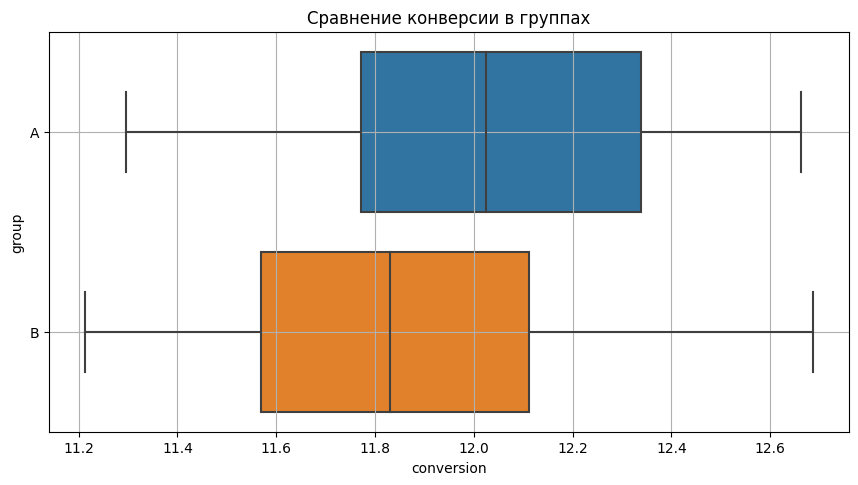

In [112]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для conversion по признаку group
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax) 
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid(True);

Что можно сказать исходя из этого графика? Во-первых, медианное значение ежедневной конверсии в группе А, выше, чем в группе B. Во-вторых, разброс конверсии в группе B несколько больше, чем в группе A.

Тут неопытный специалист воскликнет: версия рекомендаций А лучше, чем версия B (медиана конверсии варианта А больше, да и разброс поменьше, то есть конверсия более стабильна) — и завершит эксперимент. 

Но выводы делать ещё рано! И сейчас попробуем понять, почему. 

Примечание. Прежде чем делать выводы по визуальному представлению данных, всегда обращайте внимание на численные значения показателей. Они могут различаться в масштабе графика, но на практике разница между ними не будет иметь значения. Также всегда стоит убедиться, что в данных нет выбросов (базовый вариант — сравнить медиану и среднее между собой). Далее мы ещё поговорим о стабилизации показателя во времени.

Давайте вычислим средний и медианный показатель конверсии в контрольной и тестовой группе и умножим результат на 100 (получим результат в процентах):

In [113]:
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
display(conversion_piv)

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


Из полученной таблицы видно, что медиана и среднее в каждой группе практически совпадают. При этом разница между показателями в группах менее 0.3 %! 

Возникает вопрос: а значима ли вообще такая разница в показателях или она обусловлена случайностью, и варианты A и B одинаково эффективны по метрике конверсии?

Прежде чем отвечать на этот вопрос, нам нужен ответ на другой вопрос: а стабилен ли показатель конверсии в группах во времени или он колеблется как «уж на сковородке»? Вопрос о стабильности метрик является обязательным. Прогонять результаты через статистические тесты можно только после того, как вы убедитесь, что разница в ваших показателях стабилизировалась во времени. Это связано с проблемой подглядывания, речь о которой пойдёт ниже.

Тут нам помогут кумулятивные метрики.

### Кумулятивные метрики

В течение всего теста рекомендуется отслеживать поведение целевых метрик. Для этого чаще всего используются кумулятивные метрики.

Кумулятивная метрика — это отображение целевой метрики, когда вы отслеживаете её поведение за каждый день — накопленным итогом по дням. 

Ранее мы говорили, что для принятия решения в A/B-тестировании требуется большой объём данных, что соотносится с законом больших чисел: чем больше данных — тем ближе получаемый результат к математическому ожиданию (истинному среднему). 

Вспомните пример про подбрасывание монетки. Если подбросить монетку 10 раз, то велика вероятность, что один из двух результатов будет значительно превышать второй. Но если подбросить её 1 000 раз, то результаты компенсируют друг друга, и мы увидим, что итог крайне близок к разделению 50/50 (количество выпавших орлов и решек будет практически одинаковым).

Так же и в A/B-тестировании: с самого начала любой из вариантов может показывать лучшие результаты, и статистическая значимость может быть достигнута уже в первые дни теста. Это явление называется проблемой подглядывания.

Важно! Не стоит торопиться: как минимум дождитесь накопления запланированных объёмов выборки и длительности теста. Но и тут не стоит заканчивать тест — проверьте, стабилизировались ли метрики!

То есть в начале теста любой полученный за день результат будет оказывать сильное влияние на результат теста. Но со временем данные будут накапливаться, и доля получаемых за день данных будет всё меньше и меньше воздействовать на уже накопленный результат. 

Кумулятивный график конверсии может выглядеть, например, так:

![Picture1](data/dst-eda-5-19.png)

Как видите, в начале данные подвержены сильному колебанию, но со временем они выравниваются.

Кумулятивная метрика считается стабилизированной, когда на графике прекращаются резкие пики и спады показателя, и линия постепенно выравнивается в горизонтальную прямую. Важно принимать какие-либо решения только после того, как метрика стабилизируется!

Согласно центральной предельной теореме и закону больших чисел, с увеличением объёма данных метрика стабилизируется и будет стремиться к реальному среднему. 

В качестве кумулятивной метрики можно считать не только конверсию, но и выручку, средний чек, количество заказов, процент негативных комментариев, точность модели и так далее.

Итак, давайте применим новые знания к нашим данным и вычислим кумулятивную конверсию, а затем построим её график. 

Но для начала ради эксперимента посмотрим, как вообще изменялись показатели ежедневной конверсии в каждой группе во времени. Для этого построим линейные графики для каждой группы: по оси абсцисс отложим дату, а по оси ординат — показатель конверсии:

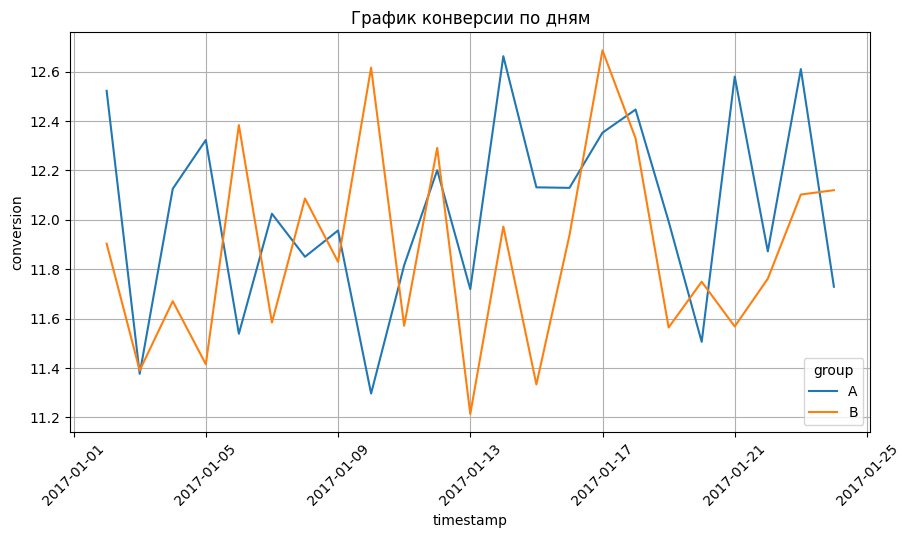

In [114]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='conversion',
    hue='group', 
    ax=ax
)
# задаём подпись к графику
ax.set_title('График конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid(True);

Что можно сказать по такому графику? Да практически ничего! Конверсия у обеих групп «скачет» день ото дня. Понять, какая из групп лучше, — практически невыполнимая задача. 

Именно поэтому и принято смотреть график кумулятивной конверсии, где за каждый день отображаются данные накопленным итогом.

Для расчёта кумулятивного показателя суммы в Pandas есть специальный метод cumsum(). Давайте посмотрим, как он работает — сначала на данных о ежедневном количестве посетителей для группы А. 

Выберем данные для группы А и создадим в полученной таблице новый столбец cum_users_count, в который запишем результат работы метода cumsum() по столбцу users_count:

In [115]:
# выделяем данные группы А
daily_data_a = daily_data[daily_data['group'] == 'A']
# считаем кумулятивное количество посетителей
daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum();
# выводим время, количество посетителей и кумулятивное количество посетителей
display(daily_data_a[['timestamp', 'users_count', 'cum_users_count']].head());

C:\Users\incon\AppData\Local\Temp\ipykernel_18264\3654022982.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum();


,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031


То есть кумулятивная сумма — это накопительная сумма; каждое её значение — это результат сложения показателя за предыдущие дни с показателем за текущий день. 

Кумулятивную сумму можно записать в виде рекурсивной формулы:

$$ S_{t} = S_{t-1} + x_{t} $$

* $ x_{t} $ — значение показателя в день $ t $;
* $ S_{t} $ — значение суммы в день $ t $.

Как сделать такой расчёт для двух групп (А и B) сразу? Воспользуемся методом groupby: сгруппируем данные по признаку группы, и в каждой группе будем вычислять кумулятивные суммы признаков количества посетителей (users_count) и количества совершённых целевых действий (converted). 

После этого рассчитаем кумулятивную конверсию — это отношение ежедневной кумулятивной суммы количества посетителей к ежедневной кумулятивной сумме количества совершённых целевых действий:

In [116]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count'] * 100
display(daily_data.head())

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


А теперь построим графики кумулятивной конверсии по дням в каждой группе:

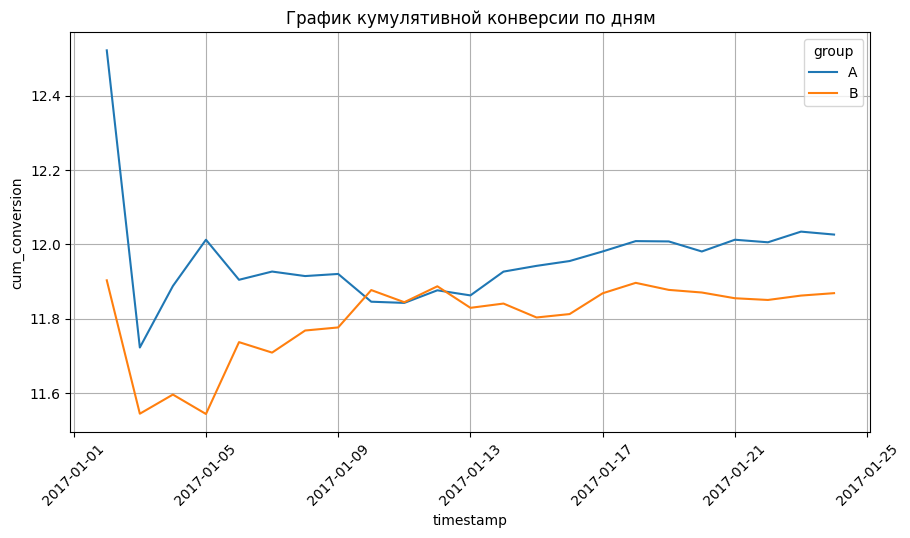

In [117]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Что можно сказать теперь? До 2017-01-09 конверсия была нестабильна, но после 2017-01-11 резкие скачки прекратились (кривая графика переходит в прямую). Судя по графику, конверсия группы B стабильно хуже конверсии группы А на всём промежутке времени. 

Обратите внимание на различие в конверсии в первые дни теста: тут наглядно отображена проблема подглядывания, когда статистическая значимость ошибочно могла быть достигнута уже в самом начале теста.

На основании стабилизированного кумулятивного графика мы можем сделать вывод, что длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателем конверсии в группах.

Значит, мы можем переходить к проведению статистических тестов. 

### ***Практическая работа***

ВВОДНЫЕ ДАННЫЕ ДЛЯ ЗАДАЧ 4.6–4.9

Проводится A/B-тестирование для двух вариантов дизайна сайта. Результаты тестирования собраны в двух файлах (данные для группы А и для группы B).

Каждая таблица имеет следующие поля:

* date — дата наблюдения;
* cid — идентификатор посетителя;
* transactions — количество совершённых целевых действий (транзакций);
* revenue — сумма покупки;
* group — группа (тестовая — А, контрольная — B).

Используйте эти данные для ответа на следующие вопросы.

In [118]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.csv')

sample_ab = pd.concat([sample_a,sample_b])

display(sample_a.head())
display(sample_b.head())
display(sample_ab.head())

,date,cid,transactions,revenue,group
0,2020-11-06,1.001648e+09,0,0,A
1,2020-11-06,1.001936e+09,0,0,A
2,2020-11-06,1.003214e+08,0,0,A
3,2020-11-06,1.004393e+09,0,0,A
4,2020-11-06,1.006382e+09,0,0,A


,date,cid,transactions,revenue,group
0,2020-11-06,1.000135e+09,0,0,B
1,2020-11-06,1.001648e+09,0,0,B
2,2020-11-06,1.003214e+08,0,0,B
3,2020-11-06,1.003652e+09,0,0,B
4,2020-11-06,1.003833e+09,0,0,B


,date,cid,transactions,revenue,group
0,2020-11-06,1.001648e+09,0,0,A
1,2020-11-06,1.001936e+09,0,0,A
2,2020-11-06,1.003214e+08,0,0,A
3,2020-11-06,1.004393e+09,0,0,A
4,2020-11-06,1.006382e+09,0,0,A


***Задание 4.6***

Постройте таблицу со следующими ежедневными показателями:

* количество посетителей сайта;
* суммарное число транзакций;
* общая сумма покупок (выручка).

Для этого сгруппируйте данные по признаку date, предварительно преобразовав его к типу datetime.

Чему равны значения ежедневных показателей в группе А на 8 ноября 2020 года?

In [119]:
# Преобразуем таблицу А
sample_a['date'] = pd.to_datetime(sample_a['date'], format='%Y-%m-%d')
daily_data_a = sample_a.groupby(['date']).agg({
    'cid':'count',
    'transactions':'sum',
    'revenue': 'sum'
}).reset_index().rename(columns={'cid': 'users_count'})

display(daily_data_a.head())

# Преобразуем таблицу В
sample_b['date'] = pd.to_datetime(sample_b['date'], format='%Y-%m-%d')
daily_data_b = sample_b.groupby(['date']).agg({
    'cid':'count',
    'transactions':'sum',
    'revenue': 'sum'
}).reset_index().rename(columns={'cid': 'users_count'})

display(daily_data_b.head())

print(daily_data_a[daily_data_a['date'] == '2020-11-08'])

# concat table 

sample_ab['date'] = pd.to_datetime(sample_b['date'], format='%Y-%m-%d')
daily_data_ab = sample_ab.groupby(['date','group']).agg({
    'cid':'count',
    'transactions':'sum',
    'revenue': 'sum'
}).reset_index().rename(columns={'cid': 'users_count'})

display(daily_data_ab.head())

,date,users_count,transactions,revenue
0,2020-11-06,2576,16,1577279
1,2020-11-07,2704,23,1721886
2,2020-11-08,3354,25,846051
3,2020-11-09,3234,18,708830
4,2020-11-10,3022,29,826984


,date,users_count,transactions,revenue
0,2020-11-06,2499,19,996645
1,2020-11-07,2804,19,555499
2,2020-11-08,3291,24,3044842
3,2020-11-09,3062,25,1285836
4,2020-11-10,3072,30,2414726


        date  users_count  transactions  revenue
2 2020-11-08         3354            25   846051


,date,group,users_count,transactions,revenue
0,2020-11-06,A,2499,15,1552379
1,2020-11-06,B,2499,19,996645
2,2020-11-07,A,2804,24,1746786
3,2020-11-07,B,2804,19,555499
4,2020-11-08,A,3291,24,816091


***Задание 4.7***

Добавьте в каждую из таблиц кумулятивные метрики:

* кумулятивное количество посетителей сайта;
* кумулятивное суммарное число транзакций;
* кумулятивная общая сумма покупок (кумулятивная выручка).

Рассчитайте кумулятивную конверсию действия покупки (в процентах) и кумулятивный средний чек (кумулятивная выручка/кумулятивное суммарное число транзакций).

Чему равна средняя кумулятивная конверсия в группах за весь период проведения A/B-теста? Ответ округлите до сотых, знаки процентов не вводите.

In [120]:
# вычисляем кумулятивную сумму количества посетителей
daily_data_ab['cum_users_count'] = daily_data_ab.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму числа транзакций
daily_data_ab['cum_transactions'] = daily_data_ab.groupby(['group'])['transactions'].cumsum()
# коммулятивная общая сумма покупок
daily_data_ab['cum_revenue'] = daily_data_ab.groupby(['group'])['revenue'].cumsum()
# вычисляем кумулятивную конверсию
daily_data_ab['cum_conversion'] = daily_data_ab['cum_transactions']/daily_data_ab['cum_users_count'] * 100
# вычисляем кумулятивный средний чек
daily_data_ab['cum_average_check'] = daily_data_ab['cum_revenue']/daily_data_ab['cum_transactions'] * 100

display(daily_data_ab.head())

print(round(daily_data_ab[daily_data_ab['group'] == 'A']['cum_conversion'].mean(), 2))
print(round(daily_data_ab[daily_data_ab['group'] == 'B']['cum_conversion'].mean(), 2))

,date,group,users_count,transactions,revenue,cum_users_count,cum_transactions,cum_revenue,cum_conversion,cum_average_check
0,2020-11-06,A,2499,15,1552379,2499,15,1552379,0.600240,1.034919e+07
1,2020-11-06,B,2499,19,996645,2499,19,996645,0.760304,5.245500e+06
2,2020-11-07,A,2804,24,1746786,5303,39,3299165,0.735433,8.459397e+06
3,2020-11-07,B,2804,19,555499,5303,38,1552144,0.716576,4.084589e+06
4,2020-11-08,A,3291,24,816091,8594,63,4115256,0.733070,6.532152e+06


0.71
0.76


***Задание 4.8***

Постройте графики кумулятивной конверсии в каждой группе. Какие выводы по ним вы можете сделать?

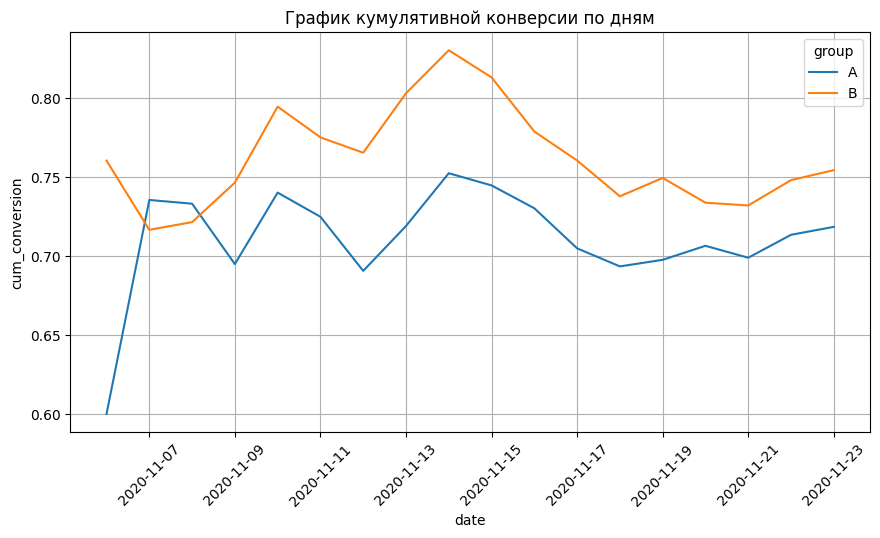

In [121]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=daily_data_ab, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

**Вывод:** Начиная с 9 ноября 2020 года конверсии в группах имеют приблизительно идентичное поведение (одинаковые точки роста и спада). При этом конверсия в группе B стабильно выше конверсии в группе A на данном периоде.

***Задание 4.9***

Постройте графики кумулятивного среднего чека в каждой группе. Какие выводы по ним вы можете сделать?

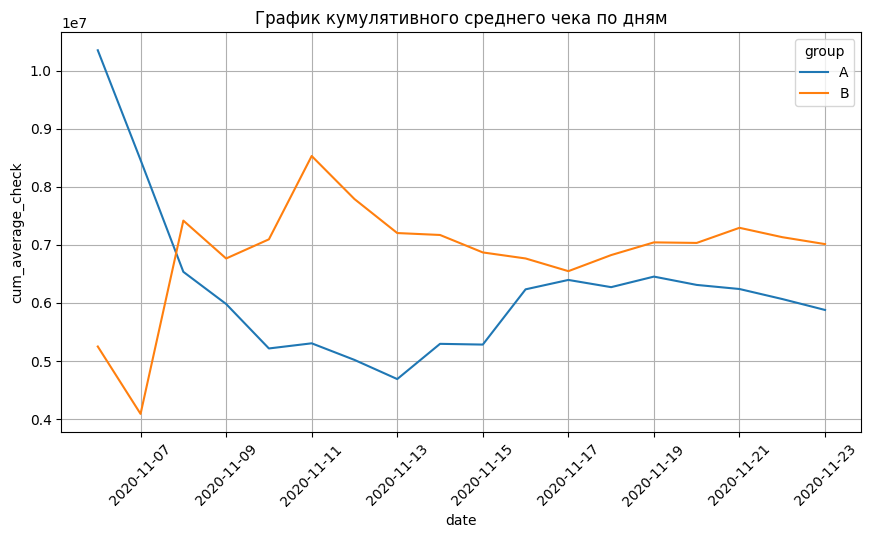

In [122]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_average_check', data=daily_data_ab, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

**Вывод:** В начале периода наблюдения средний чек в группе B был меньше, чем средний чек в группе A. Однако при стабилизации метрик наблюдается обратный результат.

Наша задача состоит в проверке гипотезы о различиях (равенстве) между истинными конверсиями в группах, исходя из выборочных конверсий. Мы хотим ответить на вопрос: «А существует ли статистическая значимость в эффективности (по конверсии) контрольного и тестового варианта?». 

## Статистический тест для конверсии

Оказывается, интересующий нас признак того, осуществлена конверсия пользователя или нет, — это случайная величина, имеющая распределение Бернулли. Такая случайная величина имеет два возможных исхода: 

* успех (1) — пользователь осуществил конверсию (совершил целевое действие); 
* неуспех (0) — пользователь не осуществил конверсию. 

Мы помним, что конверсия — это доля (пропорция) пользователей, которые добавили сопутствующий товар в корзину. То есть истинная конверсия — вероятность «успеха» (традиционно обозначают как $ p $ ), или вероятность того, что пользователь совершит целевое действие.

Для проверки гипотезы равенства пропорций мы можем воспользоваться уже знакомым нам z-критерием для пропорций. Этот критерий является наиболее популярным для задачи определения статистической значимости изменения конверсии.

Примечание. Здесь и далее, когда мы говорим о равенстве, мы не имеем в виду фактическое равенство показателей (2=2). Мы хотим узнать, есть ли статистическое различие между полученными значениями. Но для простоты изъяснения обычно говорят просто о равенстве или неравенстве.

Например, мы можем иметь конверсию в 4 % для одной группы и в 4.5 % для другой. Фактически показатели не равны. Но это не говорит о том, что конверсия для другой группы лучше — возможно, подобное отклонение в пределах допустимого для рассматриваемых данных, и тогда речь о статистическом различии идти не может.


**Нулевая гипотеза** нашего теста всегда будет звучать следующим образом:

* $ H_{0}: p_{a} = p_{b} $, то есть истинные пропорции в группах равны.

А вот альтернативных может быть несколько:

* $ H_{1}$ (двусторонняя): $ p_{a}\neq p_{b} $  , то есть истинные пропорции в группах не равны.
* $ H_{1}$ (левосторонняя): $ p_{a} < p_{b} $ , то есть истинная пропорция группы А меньше, чем в группе B.
* $ H_{1}$ (правосторонняя): $ p_{a} > p_{b} $ , то есть истинная пропорция группы А больше, чем в группе B.

Применим z-тест для пропорций на примере конверсии нашего интернет-магазина. 

Импортируем функцию proportions_ztest() из модуля statsmodels:

In [123]:
from statsmodels.stats.proportion import proportions_ztest

Напомним, что для получения z-статистики и p-value нам необходимо передать в функцию следующие аргументы:

* count — количество «успехов» (в каждой из групп). В нашем случае — количество пользователей, которые совершили целевое действие в каждой группе.
* nobs — количество наблюдений (в каждой из групп), то есть размер выборки.
* alternative — альтернативная гипотеза. Может быть: 'two-sided' — двусторонняя, 'smaller' — левосторонняя, 'larger' — правосторонняя. По умолчанию параметр равен 'two-sided'. 

Итак, сгруппируем данные по признаку группы и рассчитаем количество «успехов» (сумма по столбцу converted) и общее количество наблюдений (количество непустых значений в столбце converted) для каждой группы.

In [124]:
converted_piv= ab_data.groupby('group')['converted'].agg(
    ['sum', 'count']
)
display(converted_piv)

,sum,count
group,,
A,17467,145241
B,17238,145241


Теперь у нас с вами есть всё для того, чтобы проверить гипотезу о равенстве конверсий. 

Итак, будем проверять следующую **нулевую гипотезу**:

* $H_{0}$: $p_{a}=p_{b}$, то есть конверсии в группах А и B равны.

При **правосторонней альтернативной гипотезе** (ранее из кумулятивных графиков мы видели, что кумулятивная конверсия в группе А выше, чем в группе B, поэтому мы хотим удостовериться в этом с помощью статистического теста, и нам подойдёт правосторонняя гипотеза):

* $H_{1}$: $p_{a}>p_{b}$, то есть конверсия в группе А выше, чем конверсия в группе B.

Зададим уровень значимости $\alpha = 0.05$ и будем сравнивать полученное `p-value` с ним. По умолчанию функция proportions_ztest() возвращает `z-статистику` и `p-value` для двусторонней альтернативной гипотезы (конверсии в группах не равны). 

Z-статистика нас пока что не интересует, а вот p-value занесём в отдельную переменную для дальнейшего сравнения с уровнем значимости.

In [125]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))


p-value:  0.1
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Итак, мы получили $p-value = 0.1$. Оно больше, чем заданный уровень значимости 0.05, а значит мы должны принять нулевую гипотезу о равенстве конверсий. 

Что это значит для нас и для бизнеса? Так как z-тест для пропорций показал, что истинные значения конверсий в группах равны (с уровнем значимости 0.05), то полученная разница в метрике в группах статистически не значима. Переводим на язык бизнеса: разницы между вариантами рекомендаций сопутствующих товаров нет — они одинаково эффективны по метрике конверсии! 


На основе этого вывода мы принимаем решение о том, что делать дальше. Возможные варианты:

* отказаться от внедрения ML-модели для рекомендаций сопутствующих товаров и оставить использование текущей версии рекомендаций;
* попытаться усовершенствовать модель и провести тестирование снова;
* использовать оба варианта системы рекомендаций и посмотреть на результат в более долгосрочной перспективе.

Важно отметить, что тест для пропорций можно применять не только к конверсии. Например, так же можно оценивать долю больных людей, долю просроченных кредитов и так далее.

Заметим, что, если повысить уровень значимости до $\alpha = 0.1$, то есть «ослабить» требование по точности, можно получить уровень конверсии в группе А, всё-таки превышающий конверсию в группе B. Выполните предыдущий код, чтобы убедиться в этом. Предварительно задайте значение переменной $ \alpha = 0.1$ . 

Результат будет следующим:

In [126]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.1 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.1
Отвергаем нулевую гипотезу. Конверсии в группах А и B равны
Альтернативная гипотеза. H1: Конверсия в группе А выше, чем конверсия в группе B


Таким образом, при уровне значимости  гипотеза о равенстве конверсий всё же отвергается. В таком случае считается, что первая версия рекомендаций лучше, чем вторая версия. 

**Какой уровень значимости выбрать?**

Стараются придерживаться уровней значимости $\alpha = 0.05$ или $\alpha = 0.1$. Помним, что больший уровень значимости подразумевает больший риск совершить ошибку I рода (отклонить верную нулевую гипотезу).

Вы сами определяете уровень значимости в зависимости от вашей гипотезы и того, сколько будет стоить вам ошибка I рода.
Как правило, если возникают спорные ситуации, то склоняются в пользу уже существующего варианта А, так как он не требует временных и денежных затрат на внедрение.

В нашем примере варианты А и B оказались равными по признаку конверсии при уровне значимости $\alpha = 0.05$, однако при уровне значимости $\alpha = 0.1$ вариант А оказывается более эффективным.

Так или иначе, немедленное внедрение варианта B — определённо не лучшая идея. Либо его необходимо доработать и провести тестирование заново, либо стоит отказаться от него вовсе.

### Статистические тесты для другних метрик

На самом деле наша с вами задача об оценке эффективности двух вариантов была очень упрощена. Мы с вами рассматривали только одну метрику — конверсию добавления в корзину. Но на деле обычно смотрят на несколько показателей в комплексе!

Помимо конверсии, нужно рассматривать и другие метрики, например средний чек. Возможно же такое, что конверсия в группах одинаковая, а вот средние чеки существенно различаются! 

В таком случае проводятся статистические тесты для обеих метрик, и решение принимается в пользу варианта, который эффективнее по более приоритетной метрике (например, если мы хотим повысить прибыль, это будет средний чек).

Что делать с другими метриками?

А всё то же самое! Мы выполняем аналогичные действия: проводим визуальный анализ показателей, смотрим на кумулятивные графики, проводим статистический тест (строим доверительный интервал, речь о котором пойдёт далее) и определяем статистическую значимость разницы в показателях.

При этом важно помнить о том, что любой статистический метод имеет свою область применения, которая зависит от задачи и распределения данных. Перед тем как проводить статистический тест, важно узнать распределение метрики, по которой вы будете сравнивать. Вспомните диаграмму-алгоритм по выбору статистического теста из прошлого модуля. ![Picture2](data/dst-eda-4-10.png)

Например, время, проведённое на сайте, часто распределено нормально, и тогда мы можем использовать T-тест для средних (напомним, данный тест требует, чтобы данные были распределены нормально).

А вот денежные метрики, такие как средний чек, часто (но не всегда) напоминают логнормальное распределение (большинство распределений сосредоточены близ нуля, и частота постепенно падает):

![Picture3](data/dst-eda-5-25.png)

Для них T-тест уже не подойдёт. Здесь, как правило, используются непараметрические тесты, например критерий Манна-Уитни и другие. Данные тесты применяются в случаях, когда распределение показателя отлично от нормального.

Для проверки распределения на нормальность мы всегда можем воспользоваться тестом Шапиро-Уилка или тестом Д’Агостино$K^{2}$ .

Давайте рассмотрим следующий пример.

Мы проводим A/B-тест, чтобы оценить, влияет ли тема оформления на привлекательность сайта для пользователя. Гипотеза заключается в том, что тёмная тема более привлекательная для наших посетителей, поэтому их сильнее заинтересует наш сайт, следовательно, они проведут на нём больше времени. Уровень значимости равен 5 %.

Результаты тестирования представлены в следующем XLSX-файле:

In [127]:
time_data = pd.read_excel('data/time_data.xlsx')
display(time_data.head())

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2
3,480.0,637.2
4,561.0,712.4


Построим гистограмму времени, проведённом пользователями на сайте в каждой из групп:

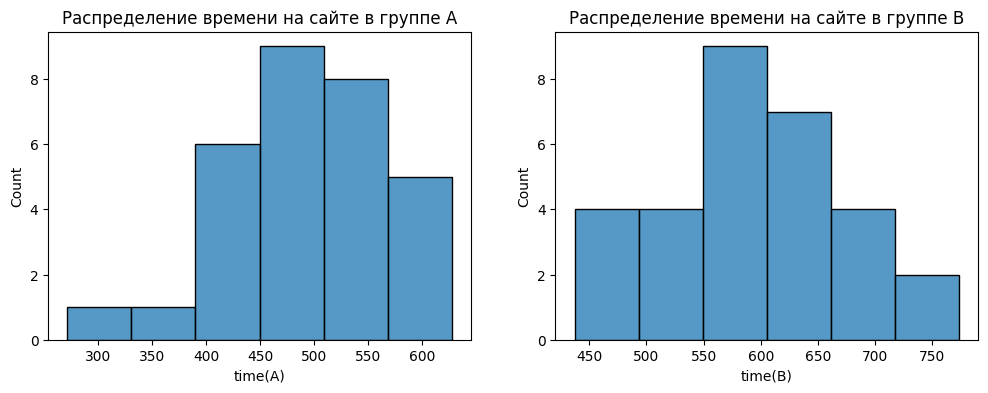

In [128]:
#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='time(A)', data=time_data, ax=axes[0])
sns.histplot(x='time(B)', data=time_data, ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');

Гистограммы напоминают нормальное распределение. Давайте проверим гипотезу о нормальности обоих распределений с помощью критерия Шапиро-Уилка. Для этого используем функцию shapiro() из модуля scipy.stats:

In [129]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(time_data['time(A)'])
shapiro_result_b = shapiro(time_data['time(B)'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.43
p-value группы B 0.12
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


Итак, распределение в обеих группах нормальное, а значит, мы можем воспользоваться T-тестом для того, чтобы сравнить среднее время посещения сайта в группах.

Выдвигаем нулевую гипотезу:

* $H_{0}: p_{a}=p_{b}$, то есть среднее время в группах А и B одинаково.

При левосторонней альтернативной гипотезе:

* $H_{1}: p_{a}<p_{b}$, то есть среднее время в группе А меньше, чем в группе B.

Применим T-тест для сравнения средних — функцию ttest_ind() из модуля scipy.stats. Обратите внимание, что левосторонняя альтернативная гипотеза в модуле scipy указывается в параметре alternative как 'less' (правосторонняя — 'greater’):

In [130]:
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Среднее время в группах одинаково'
H1 = 'Среднее время в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Среднее время в группах одинаково
Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B


Мы запрашивали значение p-value, округлённое до двух знаков после запятой, но на выводе получили 0.0 — значение только с одним знаком после запятой. Где же второй? Дело в том, что Python не выводит на конце числа больше одного нуля. Значит, 0.0 следует читать как 0.00. Без округления мы бы увидели значащие цифры далеко после запятой. Однако нас интересуют только две после запятой, потому что с такой точностью задан уровень значимости. Итак, в результате проведения T-теста мы получили $p-value = 0 < 0.05$, а это значит, что мы отвергаем нулевую гипотезу в пользу альтернативной: среднее время, проводимое на сайте, в группе А меньше, чем в группе B.

Отсюда можно сделать вывод, что что тёмная тема более привлекательна для наших посетителей, чем светлая. 

Обратите внимание, что мы опять же принимаем решение, исходя только из одной метрики, так как другими мы и не обладали. Мы проведём комплексный анализ результатов A/B-тестирования по нескольким метрикам в финальном задании модуля. А пока предлагаем вам решить несколько задач!

### ***Практическая работа***

Задание 5.2

Проверьте гипотезу о равенстве конверсий в группах А и B при альтернативной гипотезе: Конверсия в группе А меньше, чем конверсия в группе B. Используйте функцию proportions_ztest() из модуля statsmodels.stats.proportion. В качестве уровня значимости возьмите $\alpha = 0.1$.

Каковы результаты тестирования?

In [131]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсия в группах А и В равна'
H1 = 'Конверсия в группе А меньше конверсии в группе В'
alpha = 0.1 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=daily_data_ab[daily_data_ab['group']=='A']['transactions'],
    b=daily_data_ab[daily_data_ab['group']=='B']['transactions'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.26
Принимаем нулевую гипотезу. Конверсия в группах А и В равна


Задание 5.3

Проверьте гипотезу о нормальности распределений ежедневного среднего чека с помощью критерия Шапиро-Уилка. В качестве уровня значимости возьмите $\alpha = 0.1$ .

Каковы результаты тестирования?

In [132]:
alpha = 0.1

p = round(shapiro(daily_data_ab[daily_data_ab['group'] == 'A']['cum_average_check'])[1], 3)
print(f'p-value = {p}')

if p > alpha:
    print(f'{p} > {alpha}: нулевая гипотеза подтвердилась, распределение данных в группе А похоже на нормальное')
else:
    print(f'{p} <= {alpha}: данные группы А не распределены нормально, отбрасываем нулевую гипотезу')
    
alpha = 0.1

p = round(shapiro(daily_data_ab[daily_data_ab['group'] == 'B']['cum_average_check'])[1], 3)
print(f'p-value = {p}')

if p > alpha:
    print(f'{p} > {alpha}: нулевая гипотеза подтвердилась, распределение данных в группе В похоже на нормальное')
else:
    print(f'{p} <= {alpha}: данные в группе В не распределены нормально, отбрасываем нулевую гипотезу')

p-value = 0.001
0.001 <= 0.1: данные группы А не распределены нормально, отбрасываем нулевую гипотезу
p-value = 0.002
0.002 <= 0.1: данные в группе В не распределены нормально, отбрасываем нулевую гипотезу


Задание 5.4

Проверьте гипотезу о равенстве ежедневных средних чеков с помощью критерия Манна-Уитни при альтернативной гипотезе: Ежедневный средний чек в группе А меньше, чем в группе B. Используйте функцию mannwhitneyu() из модуля scipy.stats. В качестве уровня значимости возьмите $\alpha = 0.1$.

In [133]:
from scipy.stats import mannwhitneyu

alpha = 0.1
p = mannwhitneyu(daily_data_ab[daily_data_ab['group'] == 'A']['cum_average_check'],daily_data_ab[daily_data_ab['group'] == 'B']['cum_average_check'], alternative='less')[1]

if p > alpha:
    print(f'{round(p,2)} > {alpha}: распределения выборок равны')
else:
    print(f'{round(p,2)} <= {alpha}: средний чек в группе А меньше, чем в группе В')

0.0 <= 0.1: средний чек в группе А меньше, чем в группе В


Таким образом, $ z_{крит}$ — это значение, которое отсекает критическую область нормального распределения.

Это константа, которая берётся из таблицы, и её значение мы задаём, когда указываем надёжность, с которой хотим построить интервал:

$$ z_{крит} = z_{\frac{1-\gamma}{2}} = z_{\frac{\alpha}{2}} $$

где $ \gamma $ — заданный уровень надёжности (доверия);

$\alpha = 1-\gamma$ — уровень значимости.

Значение z-критического мы можем найти при помощи специальных таблиц, библиотек Python или калькулятора. Он поможет нам выяснить, что $z_{0.025}$ приблизительно равно 1.96.

Тогда:

$$ \mu = X_{mean} \pm Z_{\frac{\alpha}{2}}\times\frac{\sigma}{\sqrt{n}} $$

 Вычисления будем производить с помощью Python. 

In [134]:
n = 36 # размер выборки
x_mean = 16100 # выборочное среднее
sigma = 12000 # истинное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

Найти значение z-критического для любого уровня значимости можно при помощи функции `norm.ppf()` из модуля scipy.stats. По специфическим причинам реализации функция возвращает не совсем z-критическое, а его отрицательный модуль, поэтому мы берём его со знаком минус.

Функция `norm.ppf(x)` возвращает значение z-крит, левее (ниже) которого лежит доля $x$ левого хвоста стандартного нормального распределения. Выражение `norm.ppf(α/2)` вернёт $-z_{\frac{\alpha}{2}}$, то есть значение $z_{крит}$, ниже которого $ \frac{\alpha}{2} $ всех значений стандартного нормального распределения. Это число отрицательное, мы берём его со знаком минус, чтобы получить $z_{\frac{\alpha}{2}}$.

In [135]:
from scipy.stats import norm
z_crit = -norm.ppf(alpha/2) # z критическое

У нас есть все ингредиенты, чтобы «приготовить» доверительный интервал. Вычислим нижнюю и верхнюю границу по формуле. Округлим результат до целого и выведем на экран:

In [136]:
eps = z_crit * sigma/(n ** 0.5) #погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал: (12180, 20020)


Примечание. Заметьте, что это универсальный код. Если перед вами возникнет другая задача расчёта доверительного интервала для истинного среднего, то вам достаточно будет правильно поменять значения переменных. Вы можете оформить его в виде функции и сохранить её, чтобы не строить каждый раз новый доверительный интервал

Полученный результат интерпретируется следующим образом: мы на 95 % уверены, что истинные расходы жителей на продукты питания лежат в интервале от 12 180 рублей до 20 020 рублей. 

Важно! Доверительный интервал не даёт нам 100 % результата. Всегда есть шанс, что мы промахнулись и не захватили истинного значения. Этот шанс как раз равен уровню значимости $\alpha$.
То есть в нашем примере существует 5 %-ый шанс, что истинное среднее расходов вовсе не лежит в интервале от 12 180 до 20 020. Существует вероятность, что математическое ожидание на самом деле равно 5 000 рублей или 25 000 рублей. Но такая вероятность составляет менее 5 %, и это нас устраивает.

К сожалению, нельзя построить доверительный интервал, охватывающий 100 % возможных значений, так как границы такого доверительного интервала $-\infty$ и $+\infty$. Как мы знаем, это абстрактные математические понятия, неприменимые на практике.

### ***Практическая работа***

Задание 6.5

Аккумуляторный завод производит батарейки, срок службы которых имеет истинное стандартное отклонение в 2.4 месяца. Средний срок службы батареек в случайной выборке из 64 штук составил 12.35 месяца. Необходимо построить 90 %-ный доверительный интервал для истинного среднего срока службы производимой батарейки и ответить на вопросы заданий ниже.

Чему равно значение z-критического для такого интервала? Введите число с двумя знаками после разделительного знака.

Теперь постройте 90 %-ный доверительный интервал. Используйте критическое значение, округлённое до двух знаков. Ответ введите в виде нижней и верхней границы интервала, округляя результат до двух знаков после разделительной точки.

In [140]:
'''
* n - размер выборки
* x_mean - выборочное среднее
* sigma - истинное стандартное отклонение
* gamma - уровень надёжности

'''
def confidence_interval(n, x_mean, sigma, gamma):
    alpha = 1-gamma
    
    from scipy.stats import norm
    z_crit = -norm.ppf(alpha/2) # z критическое
    
    eps = z_crit * sigma/(n ** 0.5) #погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    result_interval = (round(lower_bound,2), round(upper_bound,2)) # создаём кортеж из округлённых границ интервала
    return result_interval

print(confidence_interval(64, 12.35, 2.4, 0.9))

alpha = 1-0.9
from scipy.stats import norm
z_crit = -norm.ppf(alpha/2) # z критическое
print(round(z_crit, 2))

(11.86, 12.84)
1.64


В реальной жизни нам приходится заменять значение $\sigma$ значением выборочного стандартного отклонения, которое мы можем посчитать на основании выборки.

Когда мы заменяем константу на случайную величину, точность всей конструкции явно становится меньше. Вероятно, итоговая величина будет похожа на нормальное распределение, но будет обладать бОльшим разбросом.

Такая случайная величина хорошо описывается распределением Стьюдента, или Т-распределением. 

Тогда в формуле для доверительного интервала случайная нормальная величина $Z$ заменится на случайную величину $T$, а истинное стандартное отклонение $\sigma$ заменится на выборочное — $X_{std}$

$$\mu = X_{mean}\pm t_{крит}\times \frac{X_{std}}{\sqrt{n}}$$

$$\mu \in (X_{mean}-t_{крит}\times \frac{X_{std}}{\sqrt{n}}; X_{mean}+t_{крит}\times \frac{X_{std}}{\sqrt{n}})$$

Значения $t_{крит}$ вычисляются аналогично $z_{крит}$: задаётся уровень надёжности (или уровень значимости $\alpha$), и на его основе по таблицам или калькуляторам для распределения Стьюдента вычисляется число. Отличие состоит в том, что для вычисления $t_{крит}$ нужно задать ещё и число степеней свободы $k=n-1$:

$$t_{крит}(k) = t_{\frac{(1-\gamma)}{2}}(k) = t_{\frac{\alpha}{2}}(k)$$

Пример.Управляющий супермаркета хочет оценить, сколько денег покупатели тратят за один поход в супермаркет в среднем. На основании ранее собранных данных известно, что расходы одного покупателя распределены приблизительно нормально. Управляющий взял случайную выборку из 15 покупателей и выяснил, что их средние расходы равны 2 000 рублей, а выборочное стандартное отклонение равно 400 рублей.

Для оценки управляющий хочет построить доверительный интервал с надёжностью в 95 %.

Давайте поможем управляющему, решив несколько задачек с помощью Python.

Итак, зададим необходимые для решения задачи переменные:

In [141]:
n = 15 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 2000 # выборочное среднее
x_std = 400 # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

Найти значение t-критического для любого уровня значимости можно, используя функцию `t.ppf()` из модуля `scipy.stats`. Для этого в функцию передаётся интересующий уровень значимости ($\frac{\alpha}{2}$) и число степеней свободы ($k = n-1$). Аналогично z-критическому функция возвращает отрицательный модуль t-критического, поэтому мы берём его со знаком минус:

In [142]:
from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) # t-критическое

Интересен тот факт, что значение t-критического при том же уровне надёжности чуть выше, чем значение z-критического, например $z_{0.025} = 1.96$, а вот $t_{0.025} = 2.02$ . Благодаря этому доверительный интервал при неизвестном стандартном отклонении гарантировано будет шире, чем при известном, если $\sigma = X_{std}$. 

Теперь составим доверительный интервал для истинного среднего. Вычислим левую и нижнюю границу по формуле. Округлим результат и выведем на экран:

In [144]:
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал: (1778, 2222)


Итак, мы на 95 % уверены, что истинные траты покупателей в нашем магазине лежат в интервале от 1 778 до 2 222 рублей. 

Примечание. Важно отметить, что при достаточной выборке (примерно более 30 наблюдений) распределение Стьюдента очень похоже на стандартное нормальное распределение. В этом случае можно использовать первую формулу (z-критическое) даже при неизвестном стандартном отклонении. Однако используя вторую формулу при оценке среднего, вы не ошибётесь.

Ещё один важный факт состоит в том, что обе формулы работают только при соблюдении двух условий:

* Выборка должна быть случайной.
* Выборка должна быть достаточно велика. Но есть исключение: если выборка маленькая, но сама величина распределена нормально, то выборочное среднее тоже будет распределено нормально. В таком случае мы можем пользоваться формулой доверительного интервала.

### ***Практическая работа***

Задание 6.6

Чиновника интересует сумма подоходного налога, выплачиваемого домохозяйствами за год. На случайной выборке из 25 домохозяйств был посчитан средний размер выплаченного налога, и он составил \$ 3 540. Также известно выборочное отклонение величины подоходного налога, равное \$ 1 150.

Необходимо найти 90 %-ый доверительный интервал для истинного среднего значения налоговых выплат за год. Используйте формулу с t-критическим.

Укажите границы построенного доверительного интервала для истинного среднего. Ответ округлите до целого.

In [146]:
n = 25 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 3540 # выборочное среднее
x_std = 1150 # выборочное стандартное отклонение
gamma = 0.9 # уровень надёжности
alpha = 1 - gamma # уровень значимости

from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) # t-критическое

eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал: (3146, 3934)


### Доверительный интервал для пропорции

Настало время вернуться к нашей задаче об анализе конверсии в двух группах A/B-тестирования.

In [147]:
ab_data = pd.read_csv('data/ab_data.csv')
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


Для удобства создадим отдельные таблицы для каждой из групп пользователей:

In [148]:
#фильтруем данные группы А
a_data = ab_data[ab_data['group'] == 'A']
#фильтруем данные группы B
b_data = ab_data[ab_data['group'] == 'B']

Давайте на этот раз оформим расчёт в виде функции: объявим функцию proportions_conf_interval(). У данной функции будет три аргумента: n — размер выборки, x_p — выборочная пропорция и gamma — уровень надёжности (по умолчанию он равен 0.95). Функция будет возвращать кортеж из вычисленных границ доверительного интервала, умноженных на 100 % и округлённых до второго знака после запятой.

In [149]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

Теперь применим нашу функцию к данным группы А и группы B:

In [150]:
conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['converted'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['converted'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.86, 12.19)
Доверительный интервал для конверсии группы B: (11.7, 12.03)


Итак, можно сделать вывод, что с надёжностью в 95 % конверсия группы А лежит в интервале от 11.86 % до 12.19 %, а конверсия группы B лежит в интервале от 11.7 % до 12.03 %.

Если схематично изобразить построенные доверительные интервалы для конверсии в группах А и B, можно отчётливо заметить пересечение интервалов (обозначено синим цветом):

![Picture3](data/dst-eda-5-33.png)

Что значит такое пересечение интервалов для нас? Это значит, что существует вероятность, что истинное значение конверсии в обеих группах может совпасть (попасть в синюю зону). То есть мы не можем однозначно сказать, есть ли разница в конверсиях. Можно даже рассчитать эту вероятность, но лучше пойти другим путём.

Лучше построить доверительный интервал разницы пропорций (конверсий).

Не будем уходить в статистические дебри, просто приведём формулу для расчёта доверительного интервала разницы конверсий в группах. Запоминать её, как и считать руками, не нужно, мы реализуем расчёты с помощью Python. Однако важно понимать её составляющие:

$$\Delta p = \Delta X_{p} \pm z_{крит} \times \sqrt{\frac{X_{p_{a}}(1-X_{p_{a}})}{n_{a}} + \frac{X_{p_{b}}(1-X_{p_{b}})}{n_{b}}}$$

* индексы $a$ и $b$ обозначают принадлежность параметра группе А и B соответственно;
* $\Delta p = p_{b} - p_{a}$ — истинная разница конверсий групп B и A;
* $\Delta X_{p} = X_{p_{b}} - X_{p_{a}}$ — выборочная разница конверсий групп B и A.

Таким образом, в центре доверительного интервала находится $\Delta X_{p}$ — это выборочная оценка, — а границы интервала задаются погрешностью $$E = z_{крит} \times \sqrt{\frac{X_{p_{a}}(1-X_{p_{a}})}{n_{a}} + \frac{X_{p_{b}}(1-X_{p_{b}})}{n_{b}}}$$

Допустим, мы построим такой доверительный интервал. Как тогда на его основе сделать выводы и принять решение? Возможны три случая:
1. Обе границы доверительного интервала являются положительными (больше 0). Истинная разница в конверсии $\Delta p = p_{b} - p_{a}$ положительная. В таком случае говорят, что вариант B более эффективен по метрике конверсии, чем вариант А с заданной надёжностью.

![Picture4](data/dst-eda-5-34.png)

2. Обе границы доверительного интервала являются отрицательными (меньше 0). Истинная разница в конверсии $\Delta p = p_{b} - p_{a}$ отрицательна. Тогда вариант B хуже по метрике конверсии, чем вариант А с заданной надёжностью.

![Picture5](data/dst-eda-5-35.png)

3. Интервал охватывает точку 0. Левая граница доверительного интервала отрицательная, а правая — положительная. То есть истинная разница в конверсии $\Delta p = p_{b} - p_{a}$ может быть как положительной, так и отрицательной. Тогда это будет значить, что варианты А и B равнозначны по метрике конверсии. 

![Picture6](data/dst-eda-5-36.png)

Создадим функцию `diff_proportions_conf_interval()` со следующими аргументами: n — список из размеров выборки для групп А и B соответственно, xp — список из выборочных пропорций для групп А и B соответственно и gamma — уровень надёжности (по умолчанию он равен 0.95). Функция будет возвращать кортеж из вычисленных границ доверительного интервала разницы конверсий, умноженных на 100 % и округлённых до второго знака после запятой.

In [151]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

Вызовем функцию и построим интересующий нас доверительный интервал:

In [152]:
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['converted'].mean(), b_data['converted'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.39, 0.08)


Итак, что можно сказать теперь? Построенный доверительный интервал с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.39 % до 0.08 %. 

То есть разница в конверсии с 95 %-ой надёжностью может быть как положительной, так и отрицательной. Мы имеем дело с третьим случаем — интервал охватывает точку 0.

Отсюда можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.

В заключение хотелось бы отметить, что доверительный интервал для пропорции применяется не только для оценки конверсии и разницы конверсий в группах!

Под истинной пропорцией может пониматься доля успешно угаданных моделью объектов (accuracy), доля выздоровевших пациентов или доля ушедших клиентов (отток). То есть такой доверительный интервал может быть применён в любой задаче A/B-тестирования, где признак, по которому считается метрика, бинарный (имеет два возможных исхода — «успех» и «неуспех»). А это очень большой спектр задач!

Таким образом, доверительные интервалы — это ещё один вспомогательный инструмент проведения A/B-тестирования, который позволяет с определённой заранее надёжностью статистически сравнить варианты продукта А и B по заданной метрике. 

Обычно доверительные интервалы используются в комплексе со статистическими тестами. Статистический тест показывает, значимы ли наши результаты, а доверительный интервал показывает пределы изменения метрик и их разницы в группах. 

### ***Практическая работа***

Задание 6.9

Чтобы оценить удовлетворённость клиентов сети отелей, менеджер взял случайную выборку из 189 комментариев, оставленных посетителями на онлайн-платформе по бронированию, и провёл анализ их содержания. Выяснилось, что 132 комментария были положительными, остальные — негативными.
Давайте поможем менеджеру ответить на несколько вопросов!

Чему равна выборочная пропорция положительных комментариев? Укажите с точностью до трёх знаков после разделительной точки.

Найдите 90 % доверительный интервал для истинной пропорции положительных комментариев. Ответ приведите в процентах и округлите до двух знаков после запятой. При расчёте используйте z-критическое.

In [161]:
n = 189
x_p = 132/n
print(round(x_p, 3))
prop_interval = proportions_conf_interval(n, x_p, gamma=0.9)
print('Доверительный интервал: {}'.format(prop_interval))

0.698
Доверительный интервал: (64.35, 75.33)


Задание 6.10

Проводится A/B-тестирование вариантов отображения страницы корзины на сайте интернет-магазина. Есть два варианта отображения страницы: с товарными рекомендациями «Хиты продаж» и персональными, подобранными под интерес конкретно этого пользователя. Метрикой является конверсия действия «добавить в корзину товар из рекомендаций». Были собраны следующие данные:

```
Группа                      Число добавленных в корзину товаров         Размер выборки

А (Персональные скидки)     45                                          1000

B (Хиты продаж)             50                                          1000
```

Постройте 95 %-ый доверительный интервал разности полученных конверсий. Ответ приведите в процентах и округлите границы интервала до второго знака после запятой. При расчёте используйте z-критическое.

In [162]:
n = [1000, 1000]
xp = [45/n[0], 50/n[1]]
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-1.36, 2.36)
